### Introduction

In this project, we'll be using the k-nearest neighbors algorithm to predict prices for cars based on their attributes.

The dataset we'll be using is taken from the UCI Machine Learning Repository, which can be found [here](https://archive.ics.uci.edu/ml/datasets/automobile).

In [1]:
import pandas as pd
cars = pd.read_csv("imports-85.data", header = None)
cars.columns = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration", "num_doors", "body_style", "drive_wheels", "engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type", "num_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]
pd.options.display.max_columns = 50
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


### Data Cleaning

Before we can get started with our predictions we need to clean the data in some of the rows. Specifically, in order to make predictions we need to make sure that none of the columns we intend to use have missing values. We can check whether there are any null values in the DataFrame using the DataFrame.info() method.

In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    205 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_doors            205 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_cylinders        205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-nul

There are no null values in our dataset, but as we saw when viewing the first five rows of it above, the normalized_losses column does contain some "?" symbols which we need to deal with. Other columns contain this symbol too. To make it easier to see which columns contain "?", let's replace all ?'s with NaN.

In [3]:
import numpy as np
cars = cars.replace("?", np.nan)

In [4]:
cars.isnull().sum()

symboling             0
normalized_losses    41
make                  0
fuel_type             0
aspiration            0
num_doors             2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

There are lots of columns here, but quite a few of them don't contain numeric values and so will not be useful to us when using our k-nearest neighbors algorithm to predict price. I'll discuss why more below, but now let's trim down our dataset so it contains only those columns that contain numeric values on non-ordinal scales and turn them into floats.

In [5]:
numeric_cols = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
numeric_cars = cars[numeric_cols]
numeric_cars = numeric_cars.astype("float")
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 14 columns):
normalized_losses    164 non-null float64
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null float64
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    205 non-null float64
horsepower           203 non-null float64
peak_rpm             203 non-null float64
city_mpg             205 non-null float64
highway_mpg          205 non-null float64
price                201 non-null float64
dtypes: float64(14)
memory usage: 22.5 KB


Ok, there are quite a few columns with null values. Most columns have only a few missing values, but the normalized_losses column has 41. We could deal with this issue in a few ways, either by dropping the column, dropping the rows, or replacing the column value for those rows with the average column value. Given the information the column contains, it is probably best not to drop it entirely. Similarly, 41 rows represents a substantial portion of the dataset, which makes removing those rows less appealing because we lose a lot of information by doing so. The best option, therefore, is to replace the null values in those columns with an average. We'll do this by replacing nan values with the mean column value.

Just because we can, we'll drop the rows of the other columns which contain null values.

In [6]:
numeric_cars["normalized_losses"] = numeric_cars["normalized_losses"].fillna(numeric_cars["normalized_losses"].mean())
numeric_cars = numeric_cars.dropna().copy()
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 14 columns):
normalized_losses    195 non-null float64
wheel_base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
curb_weight          195 non-null float64
bore                 195 non-null float64
stroke               195 non-null float64
compression_ratio    195 non-null float64
horsepower           195 non-null float64
peak_rpm             195 non-null float64
city_mpg             195 non-null float64
highway_mpg          195 non-null float64
price                195 non-null float64
dtypes: float64(14)
memory usage: 22.9 KB


Finally, we need to normalize the values in all of the columns we've selected with the exception of price (we don't normalize price because this is the value we want to predict). The reason for this is that we'll be calculating the error of our model as a single numerical figure. If the values in our columns aren't normalized, then columns which have much higher values (and therefore likely larger ranges) will far more significantly impact our calculation of our model's error. Normalizing the values in the columns means that the values in each column will have the same impact as the values in each other column when it comes to calculating our model's error.

Now, we may want certain factors to have a more significant impact on our model's error because those factors may be more or less correlated with the value we're trying to use those factors to predict (in this case, price). However, we'll ignore this here.

We'll normalize values according to the min-max scaling method, which will alter the values in the column so that they range between a minimum of 0 and maximum of 1.

To do this, we'll subtract the minimum column value from each individual value in that column, and then divide the result by the positive difference between the maximum and minimum values in that column.

In [8]:
price_col = numeric_cars['price']
# Store the values in the price column so that we can replace them after normalizing the entire DataFrame
normalized_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
# Normalize the values in the DataFrame
normalized_cars['price'] = price_col
# Replace the values in the price column with the original values
normalized_cars.head()

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


### Running a k-nearest neighbors algorithm

As I said in the introduction, we'll be predicting the price of cars based on the given attributes we've just isolated, and we'll be doing this with the k-nearest neighbors algorithm.

While one of the simplest machine learning algorithms, k-nearest neighbors (knn) still takes time to explain, and a Jupyter Notebook is not the place for this. I'll state the basic stages here, but for more information on how the knn algorithm works, I've written a post on the subject in [my blog](https://thinkingdatascience.wordpress.com/2019/02/07/the-k-nearest-neighbors-algorithm/).

There are n stages to knn: 1) Partition the dataset into a training set and test set; 2) Select which attributes (columns in the dataset) will be used to make predictions; 3) Select how many "neighbors" (k) to use, whose attributes will be used to make a prediction for an individual car; 4) Run knn on the training set, which will essentially plot each row in the dataset on an n-dimensional space, where n is the number of attributes we've chosen in step 2; 5) Make predictions on the price of cars in the test set based on their attributes. The algorithm will plot each car on our n-dimensional space, select the k points nearest to that data point (these being the most similar in their attributes to a particular car), and aggregate the price value of those nearest data points. This aggregate is the prediction. The algorithm will make this prediction for all cars in the test set. 6) Evaluate the accuracy of the predictions based on their average error (we'll use the mean). 7) Redo steps 1 through 6, choosing different attributes and different k values in steps 2 and 3. This will produce different predictions with different average errors. 8) Compare the average error of each set of predictions. The set with the lowest average error is the most accurate model.

Now that we know how our algorithm will make predictions and how to evaluate them, let's get started.

### The Univariate Case

We'll begin by writing a knn algorithm where we select only 1 attribute to base our predictions on. This is called a univariate k-nearest neighbors model.

We'll write a function to generate a prediction first, and then we'll test it on a few a different attributes to see which does best.

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def univariate_knn(training_column, target_column, DataFrame):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    shuffled_index = np.random.permutation(DataFrame.index)
    # Randomizes the index numbers of our DataFrame
    rand_data = DataFrame.reindex(shuffled_index)
    # Reorders our DataFrame based on the randomized index numbers
    partition_1_end = int(len(rand_data) / 2)
    # Finding on what row to split our data
    training_set = rand_data.iloc[0:partition_1_end]
    test_set = rand_data.iloc[partition_1_end:]
    # Partitioning our data
    knn.fit(training_set[[training_column]], training_set[target_column])
    # Fitting our data, step 4 above
    predictions = knn.predict(test_set[[training_column]])
    # Making our predictions on the test set based on the selected attribute
    mse = mean_squared_error(test_set[target_column], predictions)
    # Calculating error of our predictions
    rmse = np.sqrt(mse)
    # Converting to root mean squared error
    return(rmse)

In [27]:
rmse_results = {}
train_cols = normalized_cars.columns.drop('price')

for col in train_cols:
    rmse_val = univariate_knn(col, 'price', normalized_cars)
    rmse_results[col] = rmse_val
    
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

highway_mpg          4409.808046
city_mpg             4437.412782
horsepower           4543.271115
curb_weight          4594.668401
width                4934.118152
length               5210.375156
wheel_base           5692.794469
compression_ratio    7020.882648
bore                 7076.775614
stroke               7217.395544
peak_rpm             7313.971818
height               7574.683028
normalized_losses    7726.404961
dtype: float64

So far, then, our best univariate model uses a car's highway mpg to predict price. However, as stated above, we could alter not only the attribute we're basing our predictions on, but also how many neighbors' prices we base our predictions on. Let's do that now.

In [34]:
def univariate_knn_k(training_column, target_column, DataFrame):
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(DataFrame.index)
    rand_data = DataFrame.reindex(shuffled_index)
    
    partition_1_end = int(len(rand_data) / 2)
    
    training_set = rand_data.iloc[0:partition_1_end]
    test_set = rand_data.iloc[partition_1_end:]
    
    k_values = [1, 3, 5, 7, 9]
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(training_set[[training_column]], training_set[target_column])
        predictions = knn.predict(test_set[[training_column]])
    
        mse = mean_squared_error(test_set[target_column], predictions)
        rmse = np.sqrt(mse)
        k_rmses[k] = rmse  
    return(k_rmses)

In [35]:
attribute_k_rmses = {}

train_cols = normalized_cars.columns.drop('price')

for col in train_cols:
    rmse_val = univariate_knn_k(col, 'price', normalized_cars)
    attribute_k_rmses[col] = rmse_val
    
attribute_k_rmses

{'normalized_losses': {1: 7676.058051114624,
  3: 8218.227492879261,
  5: 7726.404961413497,
  7: 7611.964884205371,
  9: 7382.220570637262},
 'wheel_base': {1: 5718.710483302747,
  3: 5718.484995916845,
  5: 5692.794469058125,
  7: 5725.90612518176,
  9: 5840.798592662684},
 'length': {1: 5294.122074604657,
  3: 5152.07565848008,
  5: 5210.375155829933,
  7: 5380.406089801247,
  9: 5345.177600946847},
 'width': {1: 6247.139609943294,
  3: 5419.04112812399,
  5: 4934.118151510077,
  7: 4520.036899919594,
  9: 4469.768228344414},
 'height': {1: 9144.689129517208,
  3: 8163.539469846211,
  5: 7574.683028055379,
  7: 7909.810658286173,
  9: 7609.841226601191},
 'curb_weight': {1: 6739.432537578474,
  3: 5187.904039397362,
  5: 4594.66840143918,
  7: 4125.28829394039,
  9: 4175.967095661961},
 'bore': {1: 9782.241055679857,
  3: 6987.841188454177,
  5: 7076.77561366209,
  7: 7604.132316795714,
  9: 7654.952689987121},
 'stroke': {1: 7395.419041265908,
  3: 7098.713848967558,
  5: 7217.3955

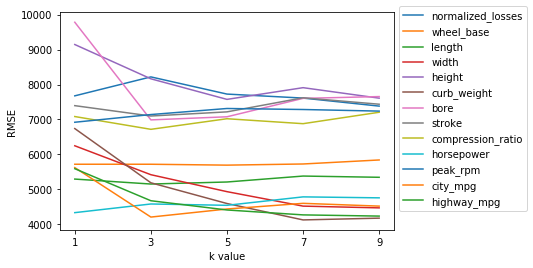

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

for k, v in attribute_k_rmses.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x, y, label = k)
    plt.legend(bbox_to_anchor=(1.0, 1.05))
    plt.xlabel("k value")
    plt.ylabel("RMSE")
    plt.xticks([1, 3, 5, 7, 9])

Now that we've tried out many possible combinations, we can see that the most accurate model was that which used curb weight as the attribute and k = 7. Other good models were city mpg with k = 3, highway mpg with k = 9, and horsepower with k = 1.

We can also see that certain attributes were never very good predictors when used by themselves. These include: compression ratio, peak rpm, normalized losses, bore, height, and stroke. Wheel base and length were also not very good attributes to use as the basis of our predictions.

### The Multivariate Case

Up to this point, when we're trying to predict the price of a specific car, we've only been looking at the prices of cars that are similar to it with regards to one attribute. For example, if we have a car that weighs 3,500 lbs, at the moment all we're doing is looking for the cars which have the most similar weights. This means that we're ignoring every other attribute of our car that might be relevant to its price. As a result, our car may have very different attributes, with the exception of weight, to the cars to which it is compared. If these attributes have a big impact on the price of a car, then we should not expect a good prediction of our cars price.

It makes sense, therefore, to base our predictions on multiple attributes of cars, given that it is likely that multiple attributes will be related to a cars price. The more attributes we use, the more similar the k nearest neighbors will be to the car whose price we're trying to predict (although, as we'll see, there is a limit).

We therefore want to change our algorithm so that it accounts for more than just a single attribute. As before, we'll start by just altering the number of attributes we use, and then we'll alter the k value.

In [51]:
def multivariate_knn(training_columns_list, target_column, DataFrame):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    shuffled_index = np.random.permutation(DataFrame.index)
    rand_data = DataFrame.reindex(shuffled_index)
    
    partition_1_end = int(len(rand_data) / 2)
    
    training_set = rand_data.iloc[0:partition_1_end]
    test_set = rand_data.iloc[partition_1_end:]
    
    knn.fit(training_set[training_columns_list], training_set[target_column])
    predictions = knn.predict(test_set[training_columns_list])
    
    mse = mean_squared_error(test_set[target_column], predictions)
    rmse = np.sqrt(mse)
    
    return(rmse)

In [55]:
combinations = [["highway_mpg", "city_mpg"],
                ["highway_mpg", "city_mpg", "horsepower"], 
                ["highway_mpg", "city_mpg", "horsepower", "curb_weight"],
                ["highway_mpg", "city_mpg", "horsepower", "curb_weight", "width"]]

rmses = {}

for combination in combinations:
    rmse = multivariate_knn(combination, "price", normalized_cars)
    key = "_".join(combination)
    rmses[key] = rmse
    
rmses

{'highway_mpg_city_mpg': 4150.431220773011,
 'highway_mpg_city_mpg_horsepower': 3562.0050421648994,
 'highway_mpg_city_mpg_horsepower_curb_weight': 3772.972620940596,
 'highway_mpg_city_mpg_horsepower_curb_weight_width': 3730.9709218915123}

While this is far from a comprehensive test of the combinations of attributes, we've selected combinations based on each individual attributes accuracy in the univariate models we used previously. Of these combinations, the most accurate is that which uses highway mpg + city mpg + horsepower. Notably, it's achieved a RMSE of almost 1,000 less than the best univariate model that we tried with k = 5. That's quite an improvement.

Now we'll try the same combinations, but we'll do so whilst changing the k value we use. We'll vary k a bit more this time, going from 1 to 20.

In [61]:
def multivariate_knn_k(training_columns, target_column, DataFrame):
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(DataFrame.index)
    rand_data = DataFrame.reindex(shuffled_index)
    
    partition_1_end = int(len(rand_data) / 2)
    
    training_set = rand_data.iloc[0:partition_1_end]
    test_set = rand_data.iloc[partition_1_end:]
    
    k_values = list(range(1, 21))
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(training_set[training_columns], training_set[target_column])
        predictions = knn.predict(test_set[training_columns])
    
        mse = mean_squared_error(test_set[target_column], predictions)
        rmse = np.sqrt(mse)
        k_rmses[k] = rmse  
    return(k_rmses)

In [67]:
multivariate_rmses = {}

for combination in combinations:
    rmses = multivariate_knn_k(combination, "price", normalized_cars)
    key = "_".join(combination)
    multivariate_rmses[key] = rmses
    
multivariate_rmses

{'highway_mpg_city_mpg': {1: 4168.353349088479,
  2: 3930.2988400296963,
  3: 4014.183692145355,
  4: 4103.664305022564,
  5: 4150.431220773011,
  6: 4171.227983089004,
  7: 4169.506141995509,
  8: 4214.556990814875,
  9: 4215.7976249474395,
  10: 4252.984329496027,
  11: 4317.014043269858,
  12: 4406.6999592466955,
  13: 4382.4868893799885,
  14: 4386.650782169045,
  15: 4475.439197697836,
  16: 4572.392064803295,
  17: 4678.847463509326,
  18: 4752.790868289748,
  19: 4839.567580037522,
  20: 4929.114167316352},
 'highway_mpg_city_mpg_horsepower': {1: 4480.25403684812,
  2: 3557.4090480578816,
  3: 3492.9074437251898,
  4: 3381.491525852647,
  5: 3562.0050421648994,
  6: 3779.233622737123,
  7: 3710.3724823427024,
  8: 3775.406613014095,
  9: 3941.5228770361136,
  10: 4135.572993318003,
  11: 4146.1685481743425,
  12: 4247.6050528777305,
  13: 4325.8889315866745,
  14: 4440.4505074989975,
  15: 4526.275630540867,
  16: 4522.802214496283,
  17: 4487.540661220769,
  18: 4559.5800773808

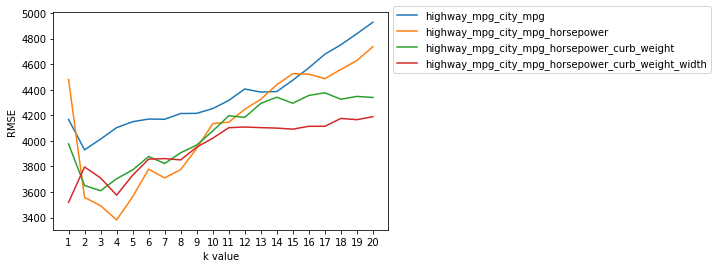

In [63]:
for k, v in multivariate_rmses.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x, y, label = k)
    plt.legend(bbox_to_anchor=(1.0, 1.05))
    plt.xlabel("k value")
    plt.ylabel("RMSE")
    plt.xticks(list(range(1, 21)))

### Conclusion

Our best model, judging by the RMSE metric, is that which bases its predictions on highway mpg, city mpg, and horsepower, and which looks at the nearest 4 neighbors.

It's worth noting that as k increases above a certain point, the RMSE also increases. Particularly interesting is that the minimum for all of these models occurs at a very low k value. This means that as we increase the number of neighbors above 4, say, we're including neighbors that are less similar to the car whose price we're trying to predict and it's negatively affecting our prediction.

One reason for this may be that our dataset is quite small (less than 200 data points), and so there are few cars in the training dataset (which has less than 100 data points) which are similar to the cars whose prices we're predicting. If there are few cars which are similar, but we're looking at 5+ neighbors, then we're forced to include the price of non-similar cars in our prediction calculation, thereby making the prediction less accurate.

Finally, there are two issues with measuring the accuracy of a model with this method which I've neglected to discuss thus far. These issues are bias and variance.

Bias describes the error that results from making bad assumption about the learning algorithm, such as assuming that few attributes relate to the value we want to predict when in fact many attributes affect that value. Variance, on the other hand, describes the error that results from the variability of a model's predicted values.

In our models, bias may be an issue. We've selected few attributes relative to the number of attributes that would be relevant, not to mention the fact that we've neglected some highly important attributes because they're not numerical-interval/numerical-ratio scales. This includes attributes such as make, fuel type, and body style.

Because we've selected few attributes and few neighbors, variance is less of an issue, but these factors may lead to increased bias. There is, therefore, a trade-off between the two, and a decision must be made about how much of one to minimize at the cost of the other.